# Project 2


In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import torchvision

## Loading the dataset CIFAR10

We are told to classify birds from cats in the CIFAR10 dataset. This means that we will only use the images that are labeled as birds or cats. In the CIFAR10 these labels are 2 and 3 respectively. We will have the training, validation and test datasets.

In [10]:
from torchvision import datasets, transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#Filtering the birds and cats images from the train set
trainset.targets = torch.tensor(trainset.targets)
mask = (trainset.targets == 2) | (trainset.targets == 3)
trainset.targets = (trainset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
trainset.data = trainset.data[mask.numpy().astype(bool)]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#Filtering the birds and cats images from the test set
testset.targets = torch.tensor(testset.targets)
mask = (testset.targets == 2) | (testset.targets == 3)
testset.targets = (testset.targets[mask] - 2)  # Adjust labels to be 0 for the birds and 1 cats
testset.data = testset.data[mask.numpy().astype(bool)]

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


Splitting the training into train and valid (80/20)

## Implementation of a Lenet5

In [11]:
class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)
                #print(torch.exp(outputs))
                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [12]:
model = Lenet5()
model.trainloop(trainloader,testloader,30)


GPU not available, running CPU
Epoch 1. Training loss: 0.574223, Validation loss: 0.528321, Time per epoch: 7.063060 seconds
Epoch 2. Training loss: 0.502953, Validation loss: 0.497446, Time per epoch: 10.209420 seconds
Epoch 3. Training loss: 0.467842, Validation loss: 0.483788, Time per epoch: 5.719755 seconds
Epoch 4. Training loss: 0.445530, Validation loss: 0.461340, Time per epoch: 5.380969 seconds
Epoch 5. Training loss: 0.425988, Validation loss: 0.467248, Time per epoch: 6.547124 seconds
Epoch 6. Training loss: 0.404596, Validation loss: 0.478160, Time per epoch: 5.369087 seconds
Epoch 7. Training loss: 0.392345, Validation loss: 0.455714, Time per epoch: 6.673039 seconds
Epoch 8. Training loss: 0.374965, Validation loss: 0.442911, Time per epoch: 5.364822 seconds
Epoch 9. Training loss: 0.356154, Validation loss: 0.481442, Time per epoch: 6.650771 seconds
Epoch 10. Training loss: 0.334540, Validation loss: 0.443393, Time per epoch: 6.151188 seconds
Epoch 11. Training loss: 0.

8 epochs for early stopping

## Computing the Calibration Curve

In [13]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]

print(predicted_prob)
print(max(predicted_prob))

[1.0, 5.277203e-05, 0.97868323, 0.9999995, 0.6316835, 0.9999995, 1.0, 0.018079283, 0.00048921694, 1.0417738e-21, 0.9999056, 5.258073e-05, 3.1538555e-05, 0.9999925, 0.5539703, 2.1942502e-05, 5.028112e-13, 0.0010027641, 1.0, 0.99999523, 1.06670605e-07, 0.9997532, 0.99166757, 0.8713202, 0.9355942, 0.9999993, 0.9551086, 0.9992084, 0.00029995805, 0.9809332, 0.99999785, 0.8326531, 1.3612256e-12, 2.140884e-08, 0.0055302926, 0.028937655, 0.02141479, 0.08648258, 0.77637917, 0.9643409, 0.99999976, 2.3958247e-08, 0.9999999, 0.9907804, 2.1398252e-13, 0.9891333, 1.0, 0.9999995, 0.0036390813, 0.007532941, 0.07262864, 0.9964742, 0.0018751653, 0.98638946, 8.07846e-05, 1.0, 0.9958593, 0.8268, 0.029880768, 0.9698713, 0.05116707, 0.9918942, 0.44935942, 0.999923, 0.09317316, 7.7817106e-07, 2.7157065e-11, 0.08954447, 0.0013108209, 0.94147193, 0.11349686, 3.5306047e-07, 8.067646e-06, 4.6969834e-08, 0.30126145, 1.2157347e-19, 1.0, 0.0015180137, 1.0, 0.95591724, 1.2750569e-05, 0.9999989, 0.9860059, 0.00411897

True labels:  [0.16985646 0.48484848 0.36363636 0.31818182 0.5        0.45454545
 0.42307692 0.48       0.54385965 0.81019523] 

Predicted Probabilities: [0.00715562 0.14404513 0.25006882 0.34776345 0.44940017 0.54972485
 0.64994017 0.75453166 0.85767467 0.99456475]


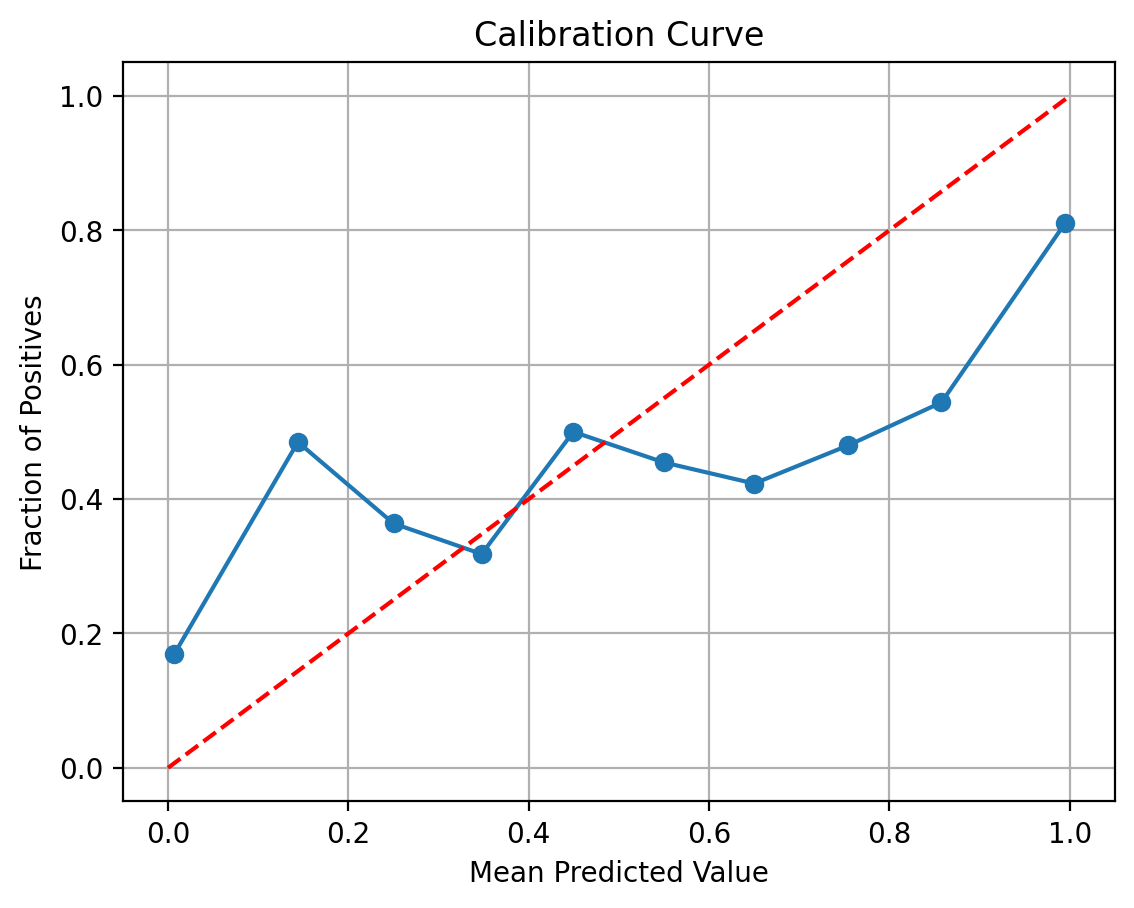

In [14]:
from sklearn.calibration import calibration_curve


prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [15]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.1792


Lenet5 regularized


In [18]:
class Lenet5_regularized(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_part = nn.Sequential( # As images are rgb we have 3 input channels
            nn.Conv2d(in_channels=3, out_channels=6,
                      kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120), # The input dimension at the classifier is 16 images of 5x5 so 16*5*5
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(84, 2), # As we are just classifying two classes the output must be 2
            #nn.LogSigmoid() # The sum does not add up to 1 as it only considers each of the classes individually.

            nn.LogSoftmax(dim = 1) # The sum adds up to 1 as it considers all the classes.

        )
        self.lr = 0.001 #Learning Rate

        self.optim = optim.Adam(self.parameters(), self.lr)

        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.NLLLoss()

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if torch.cuda.is_available():
                print("Switching to GPU")
        else:
                print("GPU not available, running CPU")

        self.to(self.device)

    def forward(self, x):
        x = self.conv_part(x)
        x = torch.flatten(x, 1) # makes the output of the images a vector
        x = self.classifier(x)
        return x

    def trainloop(self,trainloader,validloader,epochs):

        self.train()
        for e in range(epochs):

            start_time = time.time()

            running_loss = 0.

            for images, labels in trainloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out = self.forward(images)


                loss = self.criterion(out,labels)

                running_loss += loss.item()


                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():

                  self.eval()

                  running_loss = 0.

                  for images,labels in validloader:

                      # Move input and label tensors to the default device
                      images, labels = images.to(self.device), labels.to(self.device)

                      out = self.forward(images)

                      #Loss function
                      loss = self.criterion(out,labels)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(validloader))

                  self.train()


            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      %(e+1,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))

    def compute_accuracy(self, dataloader):
      correct = 0
      total = 0
      exp_outputs_list = []  # List to store torch.exp(outputs) values

      with torch.no_grad():
        self.eval()
        for images, labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self(images)

                exp_outputs_list.append(torch.exp(outputs))  # Append to the list

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
      return accuracy, exp_outputs_list


In [19]:
model = Lenet5_regularized()
model.trainloop(trainloader,testloader,8)

GPU not available, running CPU
Epoch 1. Training loss: 0.603238, Validation loss: 0.533130, Time per epoch: 7.956725 seconds
Epoch 2. Training loss: 0.506289, Validation loss: 0.488459, Time per epoch: 8.650603 seconds
Epoch 3. Training loss: 0.469671, Validation loss: 0.480124, Time per epoch: 11.508380 seconds
Epoch 4. Training loss: 0.445254, Validation loss: 0.452689, Time per epoch: 8.927525 seconds
Epoch 5. Training loss: 0.426668, Validation loss: 0.509949, Time per epoch: 8.047168 seconds
Epoch 6. Training loss: 0.415427, Validation loss: 0.452550, Time per epoch: 7.355227 seconds
Epoch 7. Training loss: 0.397213, Validation loss: 0.457829, Time per epoch: 8.062830 seconds
Epoch 8. Training loss: 0.378010, Validation loss: 0.433615, Time per epoch: 5.992336 seconds


In [41]:
# First we select the true labels of the test data
true_labels = testloader.dataset.targets.numpy()

# The store the output value of the model for each image in the test set
ac, outputs = model.compute_accuracy(testloader)
outputs = np.concatenate(outputs) # concatenate the list of tensors into a single tensor

# Now what we do is to select the first value of output if the true label is 0 and the second value if the true label is 1
predicted_prob = [outputs[i][label] if label else outputs[i][1] for i, label in enumerate(true_labels)]


True labels:  [0.07954545 0.22110553 0.28985507 0.45744681 0.5        0.58823529
 0.74657534 0.77325581 0.87313433 0.95752896] 

Predicted Probabilities: [0.03611974 0.14561228 0.24638858 0.34552572 0.45377937 0.55192674
 0.65289043 0.7545228  0.85308721 0.94422271]


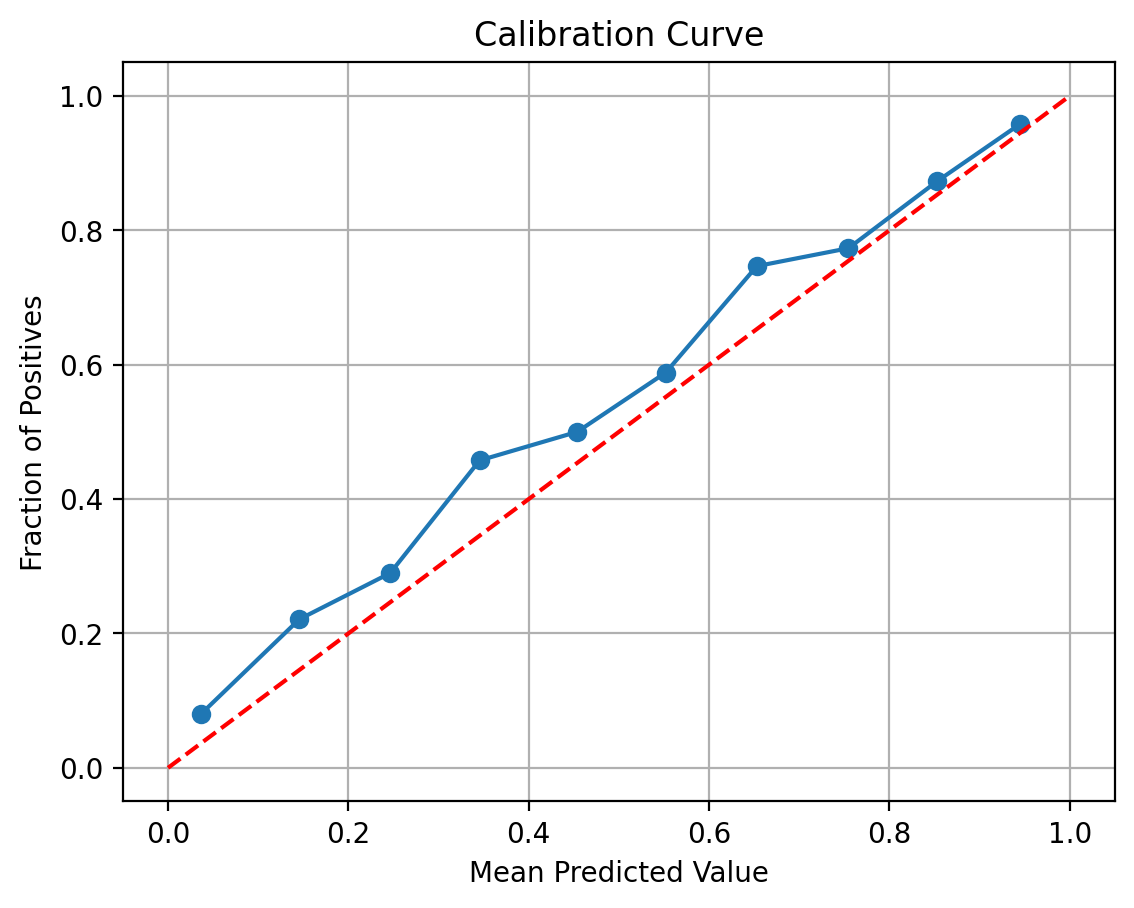

In [42]:
prob_true, prob_pred = calibration_curve(true_labels, predicted_prob, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [43]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0503


# Platt scaling

For Platt scaling we have to enter our outputs (the ones obtained for the true class) multiplied by a constant a into a new sigmoid

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Fitting a logistic regression model
lr = LogisticRegression()
lr.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Platt scaling using CalibratedClassifierCV
platt_scale = CalibratedClassifierCV(lr, method='sigmoid', cv='prefit')
platt_scale.fit(np.array(predicted_prob).reshape(-1, 1), true_labels)

# Applying Platt scaling
platt_scaled_probs = platt_scale.predict_proba(np.array(predicted_prob).reshape(-1, 1))[:, 1]

print("Original probabilities:", predicted_prob)
print("Platt scaled probabilities:", platt_scaled_probs)


Original probabilities: [0.92408895, 0.77767605, 0.07953239, 0.7155412, 0.931128, 0.88123065, 0.81750405, 0.47332123, 0.055433672, 0.004258325, 0.8115086, 0.21023673, 0.02337554, 0.94244725, 0.6885435, 0.15959527, 0.13626435, 0.20192274, 0.9675994, 0.69825345, 0.024523657, 0.818383, 0.39358705, 0.76062465, 0.016769918, 0.8147523, 0.24257694, 0.27129233, 0.05569118, 0.8427657, 0.59850067, 0.9777043, 0.41057077, 0.010375333, 0.85669, 0.34654242, 0.18760642, 0.5435031, 0.23960972, 0.22950809, 0.8691203, 0.011788706, 0.7354405, 0.86561334, 0.018804923, 0.14586444, 0.956293, 0.935036, 0.43825462, 0.25654215, 0.21425833, 0.40636113, 0.10506637, 0.9127343, 0.11216129, 0.8101603, 0.32108974, 0.16551721, 0.05130793, 0.89409125, 0.19867428, 0.57415277, 0.2002493, 0.8094441, 0.8211805, 0.013737568, 0.05549193, 0.4704104, 0.17921573, 0.28459463, 0.8002768, 0.028544838, 0.23102441, 0.04764563, 0.34112304, 0.00071624795, 0.70388836, 0.11355492, 0.89543265, 0.8191309, 0.063592196, 0.8259816, 0.436653

True labels:  [0.04508197 0.15011038 0.28387097 0.39285714 0.45901639 0.55813953
 0.66666667 0.71794872 0.8313253  0.9439528 ] 

Predicted Probabilities: [0.09310061 0.13433224 0.24452451 0.34484364 0.44798406 0.54804732
 0.65524951 0.75431144 0.86075808 0.92238041]


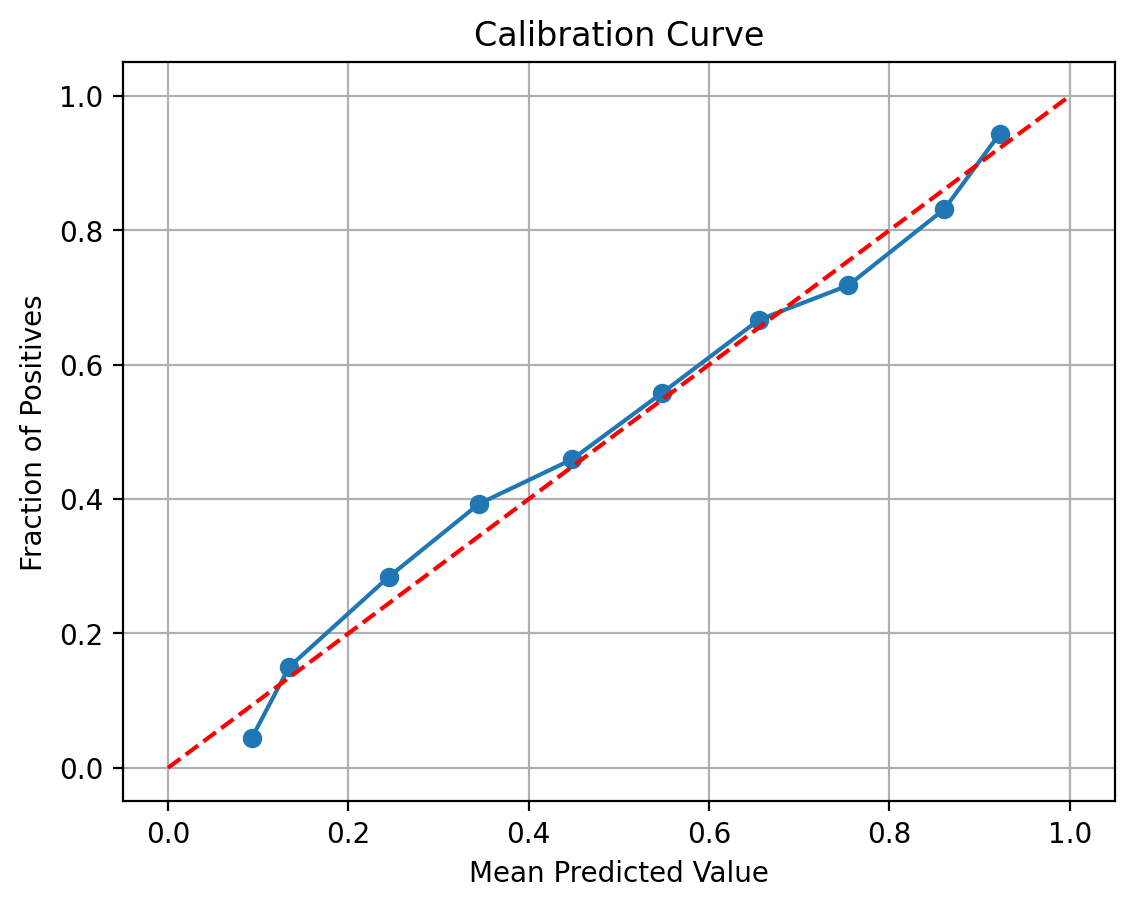

In [65]:
prob_true, prob_pred = calibration_curve(true_labels, platt_scaled_probs, n_bins=10)
print("True labels: ",prob_true, "\n")
print("Predicted Probabilities:", prob_pred)

# Plot calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Add a diagonal line for reference
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [66]:
# Assuming prob_true and prob_pred are given as in your plot and description

# Assuming equally spaced bins and uniform distribution of samples across bins for simplicity
# This is a simplification; for precise ECE, you would need the exact sample count per bin
n = len(true_labels)  # Total number of samples
M = len(prob_true)  # Number of bins
samples_per_bin = n / M  # Assuming uniform distribution of samples across bins

# vector = np.linspace(0, 1, bins)

# Compute ECE
ece = np.sum(np.abs(prob_true - prob_pred)) * (samples_per_bin / n)

print(f"Expected Calibration Error (ECE): {ece:.4f}")

Expected Calibration Error (ECE): 0.0271
